<a href="https://colab.research.google.com/github/jorgeramirez/mocogan/blob/unitn-challenge/challenge_mocogan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#We dogitclonebutwejust usethe data. We don't use the code. 
!git clone https://github.com/sergeytulyakov/mocogan.git
!ls mocogan/data/shapes


fatal: destination path 'mocogan' already exists and is not an empty directory.
0  1  local.db


#Import

In [0]:

import os

import PIL

import functools
import IPython.display
import torch.nn.functional as F

import torch
from torch.utils.data import DataLoader
from torchvision import transforms




# ContentNetwork

```
ContentNetwork(
  (fc1): Linear(in_features=x_dim, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc31): Linear(in_features=256, out_features=10, bias=True)
)
```



# models


In [0]:
"""
Copyright (C) 2017 NVIDIA Corporation.  All rights reserved.
Licensed under the CC BY-NC-ND 4.0 license (https://creativecommons.org/licenses/by-nc-nd/4.0/legalcode).
"""

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.utils.data
from torch.autograd import Variable

import numpy as np

if torch.cuda.is_available():
    T = torch.cuda
else:
    T = torch


class Noise(nn.Module):
    def __init__(self, use_noise, sigma=0.2):
        super(Noise, self).__init__()
        self.use_noise = use_noise
        self.sigma = sigma

    def forward(self, x):
        if self.use_noise:
            return x + self.sigma * Variable(T.FloatTensor(x.size()).normal_(), requires_grad=False)
        return x


class ImageDiscriminator(nn.Module):
    def __init__(self, n_channels, ndf=64, use_noise=False, noise_sigma=None):
        super(ImageDiscriminator, self).__init__()

        self.use_noise = use_noise

        self.main = nn.Sequential(
            Noise(use_noise, sigma=noise_sigma),
            nn.Conv2d(n_channels, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            Noise(use_noise, sigma=noise_sigma),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),

            Noise(use_noise, sigma=noise_sigma),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),

            Noise(use_noise, sigma=noise_sigma),
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
        )

    def forward(self, input):
        h = self.main(input).squeeze()
        return h, None


class PatchImageDiscriminator(nn.Module):
    def __init__(self, n_channels, ndf=64, use_noise=False, noise_sigma=None):
        super(PatchImageDiscriminator, self).__init__()

        self.use_noise = use_noise

        self.main = nn.Sequential(
            Noise(use_noise, sigma=noise_sigma),
            nn.Conv2d(n_channels, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            Noise(use_noise, sigma=noise_sigma),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),

            Noise(use_noise, sigma=noise_sigma),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),

            Noise(use_noise, sigma=noise_sigma),
            nn.Conv2d(ndf * 4, 1, 4, 2, 1, bias=False),
        )

    def forward(self, input):
        h = self.main(input).squeeze()
        return h, None


class PatchVideoDiscriminator(nn.Module):
    def __init__(self, n_channels, n_output_neurons=1, bn_use_gamma=True, use_noise=False, noise_sigma=None, ndf=64):
        super(PatchVideoDiscriminator, self).__init__()

        self.n_channels = n_channels
        self.n_output_neurons = n_output_neurons
        self.use_noise = use_noise
        self.bn_use_gamma = bn_use_gamma

        self.main = nn.Sequential(
            Noise(use_noise, sigma=noise_sigma),
            nn.Conv3d(n_channels, ndf, 4, stride=(1, 2, 2), padding=(0, 1, 1), bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            Noise(use_noise, sigma=noise_sigma),
            nn.Conv3d(ndf, ndf * 2, 4, stride=(1, 2, 2), padding=(0, 1, 1), bias=False),
            nn.BatchNorm3d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),

            Noise(use_noise, sigma=noise_sigma),
            nn.Conv3d(ndf * 2, ndf * 4, 4, stride=(1, 2, 2), padding=(0, 1, 1), bias=False),
            nn.BatchNorm3d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv3d(ndf * 4, 1, 4, stride=(1, 2, 2), padding=(0, 1, 1), bias=False),
        )

    def forward(self, input):
        h = self.main(input).squeeze()

        return h, None


class VideoDiscriminator(nn.Module):
    def __init__(self, n_channels, n_output_neurons=1, bn_use_gamma=True, use_noise=False, noise_sigma=None, ndf=64):
        super(VideoDiscriminator, self).__init__()

        self.n_channels = n_channels
        self.n_output_neurons = n_output_neurons
        self.use_noise = use_noise
        self.bn_use_gamma = bn_use_gamma

        self.main = nn.Sequential(
            Noise(use_noise, sigma=noise_sigma),
            nn.Conv3d(n_channels, ndf, 4, stride=(1, 2, 2), padding=(0, 1, 1), bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            Noise(use_noise, sigma=noise_sigma),
            nn.Conv3d(ndf, ndf * 2, 4, stride=(1, 2, 2), padding=(0, 1, 1), bias=False),
            nn.BatchNorm3d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),

            Noise(use_noise, sigma=noise_sigma),
            nn.Conv3d(ndf * 2, ndf * 4, 4, stride=(1, 2, 2), padding=(0, 1, 1), bias=False),
            nn.BatchNorm3d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),

            Noise(use_noise, sigma=noise_sigma),
            nn.Conv3d(ndf * 4, ndf * 8, 4, stride=(1, 2, 2), padding=(0, 1, 1), bias=False),
            nn.BatchNorm3d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv3d(ndf * 8, n_output_neurons, 4, 1, 0, bias=False),
        )

    def forward(self, input):
        h = self.main(input).squeeze()
        return h, None


class CategoricalVideoDiscriminator(VideoDiscriminator):
    def __init__(self, n_channels, dim_categorical, n_output_neurons=1, use_noise=False, noise_sigma=None):
        super(CategoricalVideoDiscriminator, self).__init__(n_channels=n_channels,
                                                            n_output_neurons=n_output_neurons + dim_categorical,
                                                            use_noise=use_noise,
                                                            noise_sigma=noise_sigma)

        self.dim_categorical = dim_categorical

    def split(self, input):
        return input[:, :input.size(1) - self.dim_categorical], input[:, input.size(1) - self.dim_categorical:]

    def forward(self, input):
        h, _ = super(CategoricalVideoDiscriminator, self).forward(input)
        labels, categ = self.split(h)
        return labels, categ


class ContentNetwork(nn.Module):
    def __init__(self, x_dim, h_dim1, z_dim):
        super(ContentNetwork, self).__init__()
        # encoder part
        self.x_dim = x_dim
        self.fc1 = nn.Linear(x_dim, h_dim1)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features//2)
        self.fc31 = nn.Linear(self.fc2.out_features, z_dim)

    def encoder(self, x):
        h1 = F.leaky_relu(self.fc1(x))
        h2 = F.leaky_relu(self.fc2(h1))
        return self.fc31(h2)

    def forward(self, x):    
        return self.encoder(x.view(-1, self.x_dim))


class VideoGenerator(nn.Module):
    def __init__(self, n_channels, dim_z_content, dim_z_category, dim_z_motion,
                 video_length, ngf=64):
        super(VideoGenerator, self).__init__()

        self.n_channels = n_channels
        self.dim_z_content = dim_z_content
        self.dim_z_category = dim_z_category
        self.dim_z_motion = dim_z_motion
        self.video_length = video_length

        dim_z = dim_z_motion + dim_z_category + dim_z_content

        self.recurrent = nn.GRUCell(dim_z_motion, dim_z_motion)

        self.main = nn.Sequential(
            nn.ConvTranspose2d(dim_z, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf, self.n_channels, 4, 2, 1, bias=False),
            nn.Tanh()
        )

        self.content_encoder = ContentNetwork(x_dim=64*64*3, h_dim1= 512, z_dim=dim_z_content)
        self.motion_encoder = ContentNetwork(x_dim=64*64*3, h_dim1= 512, z_dim=dim_z_content)

    def sample_z_m(self, num_samples, video_len=None):
        is_video = video_len is not None
        video_len = video_len if video_len is not None else self.video_length

        # TODO: replace this line by using the lines commented out. And add support for the "real_batch" parameter.
        h_t = [self.get_gru_initial_state(num_samples)]

        # if is_video:
        #   # we take the first "frame" from each video in the batch
        #   real_batch = real_batch[:, :, 0, :, :] # shape=(3, 3, 16, 64, 64)
        #   real_batch = real_batch.reshape(-1, 64*64*3)
        # else:
        #   # we turn the batch of images into a batch of videos.
        #   real_batch = real_batch.view(-1, 64*64*3)
        #   video_len *= (num_samples / real_batch.size(0)) # 16 * (320/10) = 512

        # motion = self.motion_encoder(real_batch)
        # motion = motion.repeat_interleave(video_len, dim=0)
        # h_t = motion

        for frame_num in range(video_len):
            e_t = self.get_iteration_noise(num_samples)
            h_t.append(self.recurrent(e_t, h_t[-1]))

        z_m_t = [h_k.view(-1, 1, self.dim_z_motion) for h_k in h_t]
        z_m = torch.cat(z_m_t[1:], dim=1).view(-1, self.dim_z_motion)

        return z_m

    def sample_z_categ(self, num_samples, video_len):
        video_len = video_len if video_len is not None else self.video_length

        if self.dim_z_category <= 0:
            return None, np.zeros(num_samples)

        classes_to_generate = np.random.randint(self.dim_z_category, size=num_samples)
        one_hot = np.zeros((num_samples, self.dim_z_category), dtype=np.float32)
        one_hot[np.arange(num_samples), classes_to_generate] = 1
        one_hot_video = np.repeat(one_hot, video_len, axis=0)

        one_hot_video = torch.from_numpy(one_hot_video)

        if torch.cuda.is_available():
            one_hot_video = one_hot_video.cuda()

        return Variable(one_hot_video), classes_to_generate

    def sample_z_content(self, num_samples, real_batch, video_len=None):
        is_video = video_len is not None
        video_len = video_len if video_len is not None else self.video_length
    
        if is_video:
          # we take the first "frame" from each video in the batch
          real_batch = real_batch[:, :, 0, :, :] # shape=(3, 3, 16, 64, 64)
          real_batch = real_batch.reshape(-1, 64*64*3)
        else:
          # we turn the batch of images into a "batch of videos". I still 
          # don't get the multiplication by 2.
          real_batch = real_batch.view(-1, 64*64*3)
          video_len *= (num_samples / real_batch.size(0)) # 16 * (320/10) = 512
  
        content = self.content_encoder(real_batch)
        content = content.repeat_interleave(video_len, dim=0)

        if torch.cuda.is_available():
            content = content.cuda()
        return Variable(content)

    def sample_z_video(self, num_samples, real_batch, video_len=None):
        z_content = self.sample_z_content(num_samples, real_batch, video_len)
        z_category, z_category_labels = self.sample_z_categ(num_samples, video_len)
        z_motion = self.sample_z_m(num_samples, video_len)

        if z_category is not None:
            z = torch.cat([z_content, z_category, z_motion], dim=1)
        else:
            z = torch.cat([z_content, z_motion], dim=1)

        return z, z_category_labels

    def sample_videos(self, num_samples, real_batch, video_len=None):
        video_len = video_len if video_len is not None else self.video_length

        z, z_category_labels = self.sample_z_video(num_samples, real_batch, video_len)

        h = self.main(z.view(z.size(0), z.size(1), 1, 1))
        h = h.view(h.size(0) / video_len, video_len, self.n_channels, h.size(3), h.size(3))

        z_category_labels = torch.from_numpy(z_category_labels)

        if torch.cuda.is_available():
            z_category_labels = z_category_labels.cuda()

        h = h.permute(0, 2, 1, 3, 4)
        return h, Variable(z_category_labels, requires_grad=False)

    def sample_images(self, num_samples, real_batch):
        z, z_category_labels = self.sample_z_video(num_samples * self.video_length * 2, real_batch)

        j = np.sort(np.random.choice(z.size(0), num_samples, replace=False)).astype(np.int64)
        z = z[j, ::]
        z = z.view(z.size(0), z.size(1), 1, 1)
        h = self.main(z)

        return h, None

    def get_gru_initial_state(self, num_samples):
        return Variable(T.FloatTensor(num_samples, self.dim_z_motion).normal_())

    def get_iteration_noise(self, num_samples):
        return Variable(T.FloatTensor(num_samples, self.dim_z_motion).normal_())

#data

In [0]:

"""
Copyright (C) 2017 NVIDIA Corporation.  All rights reserved.
Licensed under the CC BY-NC-ND 4.0 license (https://creativecommons.org/licenses/by-nc-nd/4.0/legalcode).
"""

import os
import tqdm
import pickle
import numpy as np
import torch.utils.data
from torchvision.datasets import ImageFolder
import PIL


class VideoFolderDataset(torch.utils.data.Dataset):
    def __init__(self, folder, cache, min_len=32):
        dataset = ImageFolder(folder)
        self.total_frames = 0
        self.lengths = []
        self.images = []

        if cache is not None and os.path.exists(cache):
            with open(cache, 'r') as f:
                self.images, self.lengths = pickle.load(f)
        else:
            for idx, (im, categ) in enumerate(
                    tqdm.tqdm(dataset, desc="Counting total number of frames")):
                img_path, _ = dataset.imgs[idx]
                shorter, longer = min(im.width, im.height), max(im.width, im.height)
                length = longer // shorter
                if length >= min_len:
                    self.images.append((img_path, categ))
                    self.lengths.append(length)

            if cache is not None:
                with open(cache, 'w') as f:
                    pickle.dump((self.images, self.lengths), f)

        self.cumsum = np.cumsum([0] + self.lengths)
        print "Total number of frames {}".format(np.sum(self.lengths))

    def __getitem__(self, item):
        path, label = self.images[item]
        im = PIL.Image.open(path)
        return im, label

    def __len__(self):
        return len(self.images)


class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset

        self.transforms = transform if transform is not None else lambda x: x

    def __getitem__(self, item):
        if item != 0:
            video_id = np.searchsorted(self.dataset.cumsum, item) - 1
            frame_num = item - self.dataset.cumsum[video_id] - 1
        else:
            video_id = 0
            frame_num = 0

        video, target = self.dataset[video_id]
        video = np.array(video)

        horizontal = video.shape[1] > video.shape[0]

        if horizontal:
            i_from, i_to = video.shape[0] * frame_num, video.shape[0] * (frame_num + 1)
            frame = video[:, i_from: i_to, ::]
        else:
            i_from, i_to = video.shape[1] * frame_num, video.shape[1] * (frame_num + 1)
            frame = video[i_from: i_to, :, ::]

        if frame.shape[0] == 0:
            print "video {}. From {} to {}. num {}".format(video.shape, i_from, i_to, item)

        return {"images": self.transforms(frame), "categories": target}

    def __len__(self):
        return self.dataset.cumsum[-1]


class VideoDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, video_length, every_nth=1, transform=None):
        self.dataset = dataset
        self.video_length = video_length
        self.every_nth = every_nth
        self.transforms = transform if transform is not None else lambda x: x

    def __getitem__(self, item):
        video, target = self.dataset[item]
        video = np.array(video)

        horizontal = video.shape[1] > video.shape[0]
        shorter, longer = min(video.shape[0], video.shape[1]), max(video.shape[0], video.shape[1])
        video_len = longer // shorter

        # videos can be of various length, we randomly sample sub-sequences
        if video_len >= self.video_length * self.every_nth:
            needed = self.every_nth * (self.video_length - 1)
            gap = video_len - needed
            start = 0 if gap == 0 else np.random.randint(0, gap, 1)[0]
            subsequence_idx = np.linspace(start, start + needed, self.video_length, endpoint=True, dtype=np.int32)
        elif video_len >= self.video_length:
            subsequence_idx = np.arange(0, self.video_length)
        else:
            raise Exception("Length is too short id - {}, len - {}").format(self.dataset[item], video_len)

        frames = np.split(video, video_len, axis=1 if horizontal else 0)
        selected = np.array([frames[s_id] for s_id in subsequence_idx])

        return {"images": self.transforms(selected), "categories": target}

    def __len__(self):
        return len(self.dataset)


class ImageSampler(torch.utils.data.Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transforms = transform

    def __getitem__(self, index):
        result = {}
        for k in self.dataset.keys:
            result[k] = np.take(self.dataset.get_data()[k], index, axis=0)

        if self.transforms is not None:
            for k, transform in self.transforms.iteritems():
                result[k] = transform(result[k])

        return result

    def __len__(self):
        return self.dataset.get_data()[self.dataset.keys[0]].shape[0]


class VideoSampler(torch.utils.data.Dataset):
    def __init__(self, dataset, video_length, every_nth=1, transform=None):
        self.dataset = dataset
        self.video_length = video_length
        self.unique_ids = np.unique(self.dataset.get_data()['video_ids'])
        self.every_nth = every_nth
        self.transforms = transform

    def __getitem__(self, item):
        result = {}
        ids = self.dataset.get_data()['video_ids'] == self.unique_ids[item]
        ids = np.squeeze(np.squeeze(np.argwhere(ids)))
        for k in self.dataset.keys:
            result[k] = np.take(self.dataset.get_data()[k], ids, axis=0)

        subsequence_idx = None
        print result[k].shape[0]

        # videos can be of various length, we randomly sample sub-sequences
        if result[k].shape[0] > self.video_length:
            needed = self.every_nth * (self.video_length - 1)
            gap = result[k].shape[0] - needed
            start = 0 if gap == 0 else np.random.randint(0, gap, 1)[0]
            subsequence_idx = np.linspace(start, start + needed, self.video_length, endpoint=True, dtype=np.int32)
        elif result[k].shape[0] == self.video_length:
            subsequence_idx = np.arange(0, self.video_length)
        else:
            print "Length is too short id - {}, len - {}".format(self.unique_ids[item], result[k].shape[0])

        if subsequence_idx:
            for k in self.dataset.keys:
                result[k] = np.take(result[k], subsequence_idx, axis=0)
        else:
            print result[self.dataset.keys[0]].shape

        if self.transforms is not None:
            for k, transform in self.transforms.iteritems():
                result[k] = transform(result[k])

        return result

    def __len__(self):
        return len(self.unique_ids)

#Logger

In [0]:
"""
Copyright (C) 2017 NVIDIA Corporation.  All rights reserved.
Licensed under the CC BY-NC-ND 4.0 license (https://creativecommons.org/licenses/by-nc-nd/4.0/legalcode).
"""

import tensorflow as tf
import numpy as np
import scipy.misc

try:
    from StringIO import StringIO  # Python 2.7
except ImportError:
    from io import BytesIO  # Python 3.x


class Logger(object):
    def __init__(self, log_dir, suffix=None):
        self.writer = tf.summary.FileWriter(log_dir, filename_suffix=suffix)

    def scalar_summary(self, tag, value, step):
        summary = tf.Summary(value=[tf.Summary.Value(tag=tag, simple_value=value)])
        self.writer.add_summary(summary, step)

    def image_summary(self, tag, images, step):

        img_summaries = []
        for i, img in enumerate(images):
            # Write the image to a string
            try:
                s = StringIO()
            except:
                s = BytesIO()
            scipy.misc.toimage(img).save(s, format="png")

            # Create an Image object
            img_sum = tf.Summary.Image(encoded_image_string=s.getvalue(),
                                       height=img.shape[0],
                                       width=img.shape[1])
            # Create a Summary value
            img_summaries.append(tf.Summary.Value(tag='%s/%d' % (tag, i), image=img_sum))

        # Create and write Summary
        summary = tf.Summary(value=img_summaries)
        self.writer.add_summary(summary, step)
        self.writer.flush()

    def video_summary(self, tag, videos, step):

        sh = list(videos.shape)
        sh[-1] = 1

        separator = np.zeros(sh, dtype=videos.dtype)
        videos = np.concatenate([videos, separator], axis=-1)

        img_summaries = []
        for i, vid in enumerate(videos):
            # Concat a video
            try:
                s = StringIO()
            except:
                s = BytesIO()

            v = vid.transpose(1, 2, 3, 0)
            v = [np.squeeze(f) for f in np.split(v, v.shape[0], axis=0)]
            img = np.concatenate(v, axis=1)[:, :-1, :]

            #scipy.misc.toimage(img).save(s, format="png")

            f = StringIO()
            PIL.Image.fromarray(img).save(f, "png")
            IPython.display.display(IPython.display.Image(data=f.getvalue()))
            
            # Create an Image object
            img_sum = tf.Summary.Image(encoded_image_string=s.getvalue(),
                                       height=img.shape[0],
                                       width=img.shape[1])
            # Create a Summary value
            img_summaries.append(tf.Summary.Value(tag='%s/%d' % (tag, i), image=img_sum))

        # Create and write Summary
        summary = tf.Summary(value=img_summaries)
        self.writer.add_summary(summary, step)
        self.writer.flush()

#Trainer


In [0]:
"""
Copyright (C) 2017 NVIDIA Corporation.  All rights reserved.
Licensed under the CC BY-NC-ND 4.0 license (https://creativecommons.org/licenses/by-nc-nd/4.0/legalcode).
"""

import os
import time

import numpy as np

import torch
from torch import nn

from torch.autograd import Variable
import torch.optim as optim

if torch.cuda.is_available():
    T = torch.cuda
else:
    T = torch


def images_to_numpy(tensor):
    generated = tensor.data.cpu().numpy().transpose(0, 2, 3, 1)
    generated[generated < -1] = -1
    generated[generated > 1] = 1
    generated = (generated + 1) / 2 * 255
    return generated.astype('uint8')


def videos_to_numpy(tensor):
    generated = tensor.data.cpu().numpy().transpose(0, 1, 2, 3, 4)
    generated[generated < -1] = -1
    generated[generated > 1] = 1
    generated = (generated + 1) / 2 * 255
    return generated.astype('uint8')


def one_hot_to_class(tensor):
    a, b = np.nonzero(tensor)
    return np.unique(b).astype(np.int32)


class Trainer(object):
    def __init__(self, image_sampler, video_sampler, log_interval, train_batches, log_folder, use_cuda=False,
                 use_infogan=True, use_categories=True):

        self.use_categories = use_categories

        self.gan_criterion = nn.BCEWithLogitsLoss()
        self.category_criterion = nn.CrossEntropyLoss()

        self.image_sampler = image_sampler
        self.video_sampler = video_sampler

        self.video_batch_size = self.video_sampler.batch_size
        self.image_batch_size = self.image_sampler.batch_size

        self.log_interval = log_interval
        self.train_batches = train_batches

        self.log_folder = log_folder

        self.use_cuda = use_cuda
        self.use_infogan = use_infogan

        self.image_enumerator = None
        self.video_enumerator = None

    @staticmethod
    def ones_like(tensor, val=1.):
        return Variable(T.FloatTensor(tensor.size()).fill_(val), requires_grad=False)

    @staticmethod
    def zeros_like(tensor, val=0.):
        return Variable(T.FloatTensor(tensor.size()).fill_(val), requires_grad=False)

    def compute_gan_loss(self, discriminator, sample_true, sample_fake, is_video):
        real_batch = sample_true()

        batch_size = real_batch['images'].size(0)
        fake_batch, generated_categories = sample_fake(batch_size)

        real_labels, real_categorical = discriminator(Variable(real_batch['images']))
        fake_labels, fake_categorical = discriminator(fake_batch)

        fake_gt, real_gt = self.get_gt_for_discriminator(batch_size, real=0.)

        l_discriminator = self.gan_criterion(real_labels, real_gt) + \
                          self.gan_criterion(fake_labels, fake_gt)

        # update image discriminator here

        # sample again for videos

        # update video discriminator

        # sample again
        # - videos
        # - images

        # l_vidoes + l_images -> l
        # l.backward()
        # opt.step()


        #  sample again and compute for generator

        fake_gt = self.get_gt_for_generator(batch_size)
        # to real_gt
        l_generator = self.gan_criterion(fake_labels, fake_gt)

        if is_video:

            # Ask the video discriminator to learn categories from training videos
            categories_gt = Variable(torch.squeeze(real_batch['categories'].long()))
            l_discriminator += self.category_criterion(real_categorical, categories_gt)

            if self.use_infogan:
                # Ask the generator to generate categories recognizable by the discriminator
                l_generator += self.category_criterion(fake_categorical, generated_categories)

        return l_generator, l_discriminator

    def sample_real_image_batch(self):
        if self.image_enumerator is None:
            self.image_enumerator = enumerate(self.image_sampler)

        batch_idx, batch = next(self.image_enumerator)
        b = batch
        if self.use_cuda:
            for k, v in batch.iteritems():
                b[k] = v.cuda()

        if batch_idx == len(self.image_sampler) - 1:
            self.image_enumerator = enumerate(self.image_sampler)
        return b

    def sample_real_video_batch(self):
        if self.video_enumerator is None:
            self.video_enumerator = enumerate(self.video_sampler)

        batch_idx, batch = next(self.video_enumerator)
        b = batch
        if self.use_cuda:
            for k, v in batch.iteritems():
                b[k] = v.cuda()

        if batch_idx == len(self.video_sampler) - 1:
            self.video_enumerator = enumerate(self.video_sampler)
        return b

    def train_discriminator(self, discriminator, sample_true, sample_fake, opt, batch_size, use_categories):
        opt.zero_grad()

        real_batch = sample_true()
        batch = Variable(real_batch['images'], requires_grad=False)

        # util.show_batch(batch.data)

        fake_batch, generated_categories = sample_fake(batch_size, batch)

        real_labels, real_categorical = discriminator(batch)
        fake_labels, fake_categorical = discriminator(fake_batch.detach())

        ones = self.ones_like(real_labels)
        zeros = self.zeros_like(fake_labels)

        l_discriminator = self.gan_criterion(real_labels, ones) + \
                          self.gan_criterion(fake_labels, zeros)

        if use_categories:
            # Ask the video discriminator to learn categories from training videos
            categories_gt = Variable(torch.squeeze(real_batch['categories'].long()), requires_grad=False)
            l_discriminator += self.category_criterion(real_categorical.squeeze(), categories_gt)

        l_discriminator.backward()
        opt.step()

        return l_discriminator, batch

    def train_generator(self,
                        image_discriminator, video_discriminator,
                        sample_fake_images, sample_fake_videos,
                        opt, batch_images, batch_videos):

        opt.zero_grad()

        # train on images

        fake_batch, generated_categories = sample_fake_images(self.image_batch_size, batch_images)
        fake_labels, fake_categorical = image_discriminator(fake_batch)
        all_ones = self.ones_like(fake_labels)

        l_generator = self.gan_criterion(fake_labels, all_ones)

        # train on videos

        fake_batch, generated_categories = sample_fake_videos(self.video_batch_size, batch_videos)
        fake_labels, fake_categorical = video_discriminator(fake_batch)
        all_ones = self.ones_like(fake_labels)

        l_generator += self.gan_criterion(fake_labels, all_ones)
        
        # reconstruction loss
        RecLoss = F.mse_loss(fake_batch, batch_videos)
        l_generator += RecLoss

        if self.use_infogan:
            # Ask the generator to generate categories recognizable by the discriminator
            l_generator += self.category_criterion(fake_categorical.squeeze(), generated_categories)  

        l_generator.backward()
        opt.step()

        return l_generator

    def train(self, generator, image_discriminator, video_discriminator):
        if self.use_cuda:
            generator.cuda()
            image_discriminator.cuda()
            video_discriminator.cuda()

        logger = Logger(self.log_folder)

        # create optimizers
        opt_generator = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999), weight_decay=0.00001)
        opt_image_discriminator = optim.Adam(image_discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999),
                                             weight_decay=0.00001)
        opt_video_discriminator = optim.Adam(video_discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999),
                                             weight_decay=0.00001)

        # training loop

        def sample_fake_image_batch(batch_size, batch_images):
            return generator.sample_images(batch_size, batch_images)

        def sample_fake_video_batch(batch_size, batch_videos):
            return generator.sample_videos(batch_size, batch_videos)

        def init_logs():
            return {'l_gen': 0, 'l_image_dis': 0, 'l_video_dis': 0}

        batch_num = 0

        logs = init_logs()

        start_time = time.time()

        while True:
            generator.train()
            image_discriminator.train()
            video_discriminator.train()

            opt_generator.zero_grad()

            opt_video_discriminator.zero_grad()

            # train image discriminator
            l_image_dis, batch_images = self.train_discriminator(image_discriminator, self.sample_real_image_batch,
                                                   sample_fake_image_batch, opt_image_discriminator,
                                                   self.image_batch_size, use_categories=False)

            # train video discriminator
            l_video_dis, batch_videos = self.train_discriminator(video_discriminator, self.sample_real_video_batch,
                                                   sample_fake_video_batch, opt_video_discriminator,
                                                   self.video_batch_size, use_categories=self.use_categories)

            # train generator
            l_gen = self.train_generator(image_discriminator, video_discriminator,
                                         sample_fake_image_batch, sample_fake_video_batch,
                                         opt_generator, batch_images, batch_videos)

            logs['l_gen'] += l_gen.data

            logs['l_image_dis'] += l_image_dis.data
            logs['l_video_dis'] += l_video_dis.data

            batch_num += 1

            if batch_num % self.log_interval == 0:

                log_string = "Batch %d" % batch_num
                for k, v in logs.iteritems():
                    log_string += " [%s] %5.3f" % (k, v / self.log_interval)

                log_string += ". Took %5.2f" % (time.time() - start_time)

                print log_string

                for tag, value in logs.items():
                    logger.scalar_summary(tag, value / self.log_interval, batch_num)

                logs = init_logs()
                start_time = time.time()

                generator.eval()

                images, _ = sample_fake_image_batch(self.image_batch_size, batch_images)
                logger.image_summary("Images", images_to_numpy(images), batch_num)

                videos, _ = sample_fake_video_batch(self.video_batch_size, batch_videos)
                logger.video_summary("Videos", videos_to_numpy(videos), batch_num)

                torch.save(generator, os.path.join(self.log_folder, 'generator_%05d.pytorch' % batch_num))

            if batch_num >= self.train_batches:
                torch.save(generator, os.path.join(self.log_folder, 'generator_%05d.pytorch' % batch_num))
                break

#Main

Total number of frames 256000
Batch 30 [l_image_dis] 0.553 [l_video_dis] 2.071 [l_gen] 13.522. Took  9.57


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:33: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.


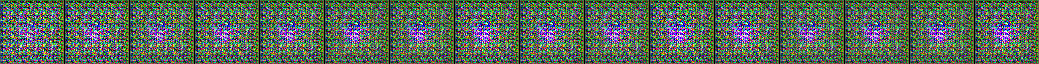

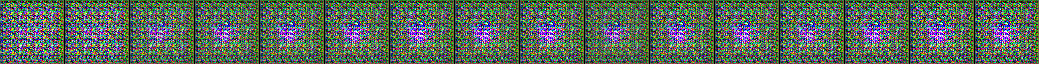

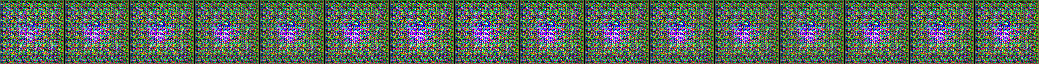

Batch 60 [l_image_dis] 0.158 [l_video_dis] 0.938 [l_gen] 15.024. Took  9.46


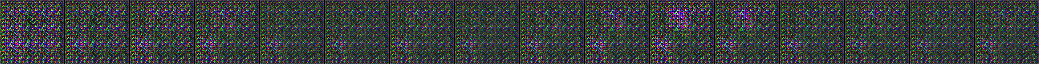

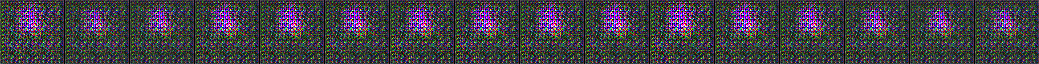

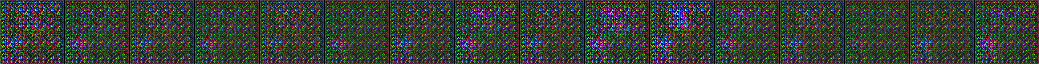

Batch 90 [l_image_dis] 0.264 [l_video_dis] 1.485 [l_gen] 11.274. Took  9.38


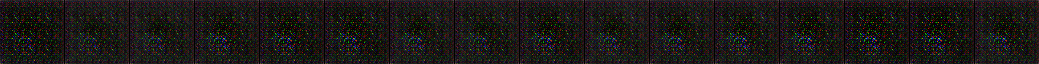

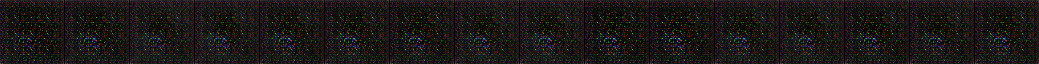

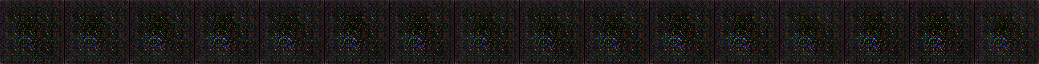

Batch 120 [l_image_dis] 0.487 [l_video_dis] 1.189 [l_gen] 10.030. Took  9.40


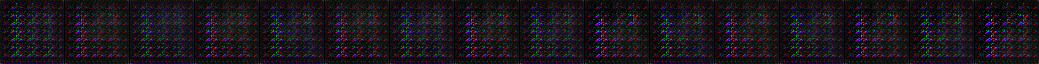

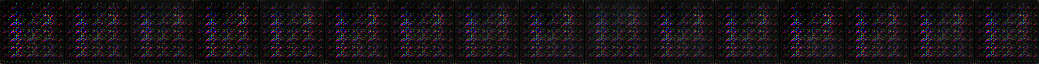

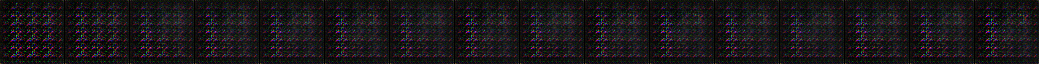

Batch 150 [l_image_dis] 0.321 [l_video_dis] 0.746 [l_gen] 9.504. Took  9.39


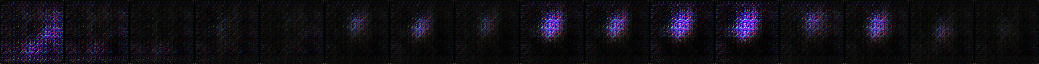

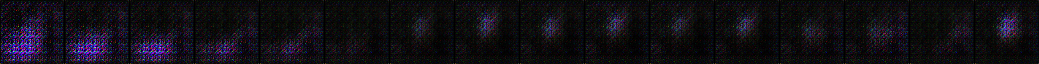

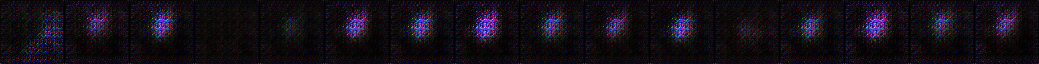

Batch 180 [l_image_dis] 0.621 [l_video_dis] 0.408 [l_gen] 7.252. Took  9.42


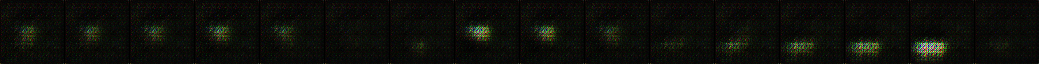

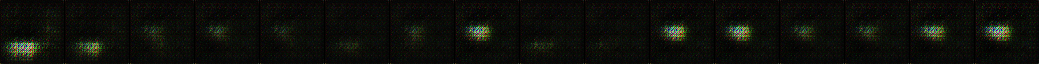

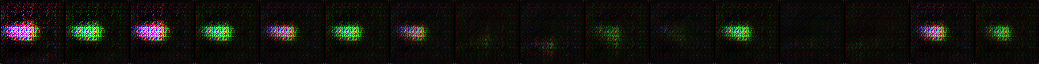

Batch 210 [l_image_dis] 0.690 [l_video_dis] 0.285 [l_gen] 8.082. Took  9.38


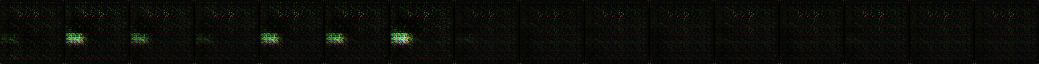

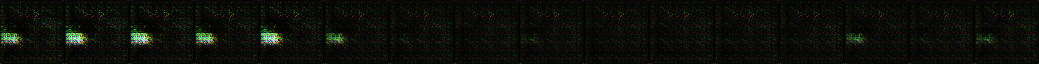

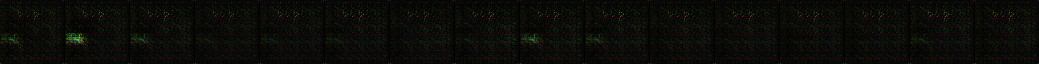

Batch 240 [l_image_dis] 0.514 [l_video_dis] 0.224 [l_gen] 8.603. Took  9.33


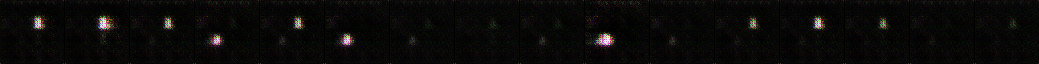

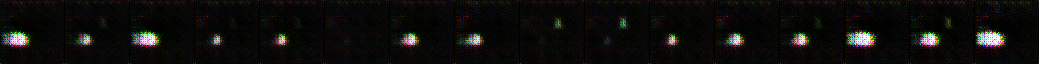

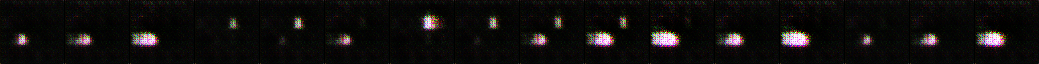

Batch 270 [l_image_dis] 0.467 [l_video_dis] 0.310 [l_gen] 10.975. Took  9.38


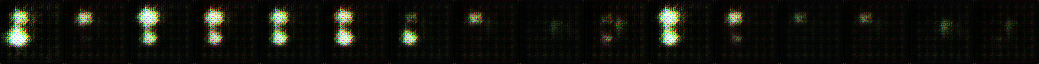

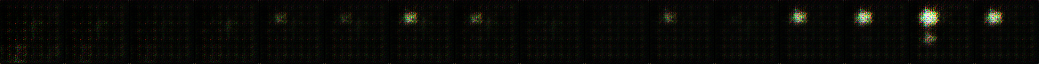

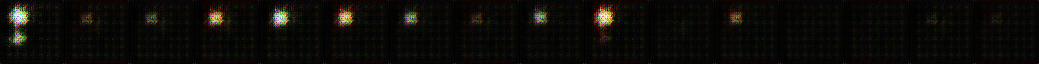

Batch 300 [l_image_dis] 0.679 [l_video_dis] 0.179 [l_gen] 8.982. Took  9.34


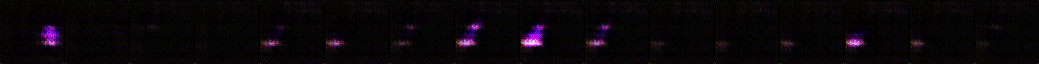

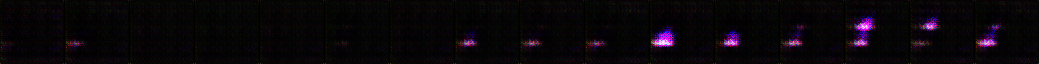

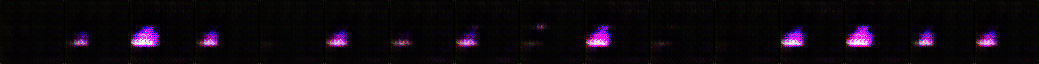

Batch 330 [l_image_dis] 0.508 [l_video_dis] 0.099 [l_gen] 9.764. Took  9.46


In [0]:
def build_discriminator(type, **kwargs):
  if type=="PatchImageDiscriminator":
    return PatchImageDiscriminator(**kwargs)#discriminator_type(**kwargs)
  if type=="CategoricalVideoDiscriminator":
    return CategoricalVideoDiscriminator(**kwargs)#discriminator_type(**kwargs)


def video_transform(video, image_transform):
    vid = []
    for im in video:
        vid.append(image_transform(im))

    vid = torch.stack(vid).permute(1, 0, 2, 3)

    return vid


img_size=64
video_length = 16
image_batch = 10
video_batch = 3

dim_z_content = 10
dim_z_motion = 10
dim_z_category = 2
print_every=30
batches=100000
log_folder="./" 
use_infogan=0
use_categories=1


image_discriminator="PatchImageDiscriminator"
video_discriminator="CategoricalVideoDiscriminator"
use_noise=0
noise_sigma = 0
n_channels = 3
dataset="mocogan/data/shapes" 

image_transforms = transforms.Compose([
    PIL.Image.fromarray,
    transforms.Scale(img_size),
    transforms.ToTensor(),
    lambda x: x[:n_channels, ::],
    transforms.Normalize((0.5, 0.5, .5), (0.5, 0.5, 0.5)),
])

video_transforms = functools.partial(video_transform, image_transform=image_transforms)



dataset = VideoFolderDataset(dataset, cache=os.path.join(dataset, 'local.db'))
image_dataset = ImageDataset(dataset, image_transforms)
image_loader = DataLoader(image_dataset, batch_size=image_batch, drop_last=True, num_workers=2, shuffle=True)


video_dataset = VideoDataset(dataset, 16, 2, video_transforms)
video_loader = DataLoader(video_dataset, batch_size=video_batch, drop_last=True, num_workers=2, shuffle=True)

generator = VideoGenerator(n_channels, dim_z_content, dim_z_category, dim_z_motion, video_length)

image_discriminator = build_discriminator(image_discriminator, n_channels=n_channels,
                                          use_noise=use_noise, noise_sigma=noise_sigma)

video_discriminator = build_discriminator(video_discriminator, dim_categorical=dim_z_category,
                                          n_channels=n_channels, use_noise=use_noise,
                                          noise_sigma=noise_sigma)

if torch.cuda.is_available():
    generator.cuda()
    image_discriminator.cuda()
    video_discriminator.cuda()

trainer = Trainer(image_loader, video_loader,
                  print_every,
                  batches,
                  log_folder,
                  use_cuda=torch.cuda.is_available(),
                  use_infogan=use_infogan,
                  use_categories=use_categories)

trainer.train(generator, image_discriminator, video_discriminator)